# Students:

# Adi Dereviani - 305674731
# Stav Cohen - 316492776

In this homework assignment, you are requested to implement a full backprop algorithm using only *numpy*.

- We assume sigmoid activation across all layers.
- We assume a single value in the output layer

In [1]:
import numpy as np
np.random.seed(42)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

The following class represents a simple feed forward network with multiple layers. The network class provides methods for running forward and backward for a single instance, throught the network. You should implement the methods (indicated with TODO), that performs forward and backward for an entire batch. Note, the idea is to use matrix multiplications, and not running standard loops over the instances in the batch.

In [3]:
class MyNN:
  def __init__(self, learning_rate, layer_sizes):
    '''
    learning_rate - the learning to use in backward
    layer_sizes - a list of numbers, each number repreents the nuber of neurons
                  to have in every layer. Therfore, the length of the list
                  represents the number layers this network has.
    '''
    self.learning_rate = learning_rate
    self.layer_sizes = layer_sizes
    self.model_params = {}
    self.memory = {}
    self.grads = {}

    # Initializing weights
    for layer_index in range(len(layer_sizes) - 1):
      W_input = layer_sizes[layer_index + 1]
      W_output = layer_sizes[layer_index]
      self.model_params['W_' + str(layer_index + 1)] = np.random.randn(W_input, W_output) * 0.1
      self.model_params['b_' + str(layer_index + 1)] = np.random.randn(W_input) * 0.1


  def forward_single_instance(self, x):
    a_i_1 = x
    self.memory['a_0'] = x
    for layer_index in range(len(self.layer_sizes) - 1):
      W_i = self.model_params['W_' + str(layer_index + 1)]
      b_i = self.model_params['b_' + str(layer_index + 1)]
      z_i = np.dot(W_i, a_i_1) + b_i
      a_i = 1/(1+np.exp(-z_i))
      self.memory['a_' + str(layer_index + 1)] = a_i
      a_i_1 = a_i
    return a_i_1


  def log_loss(self, y_hat, y):
    '''
    Logistic loss, assuming a single value in y_hat and y.
    '''
    m = y_hat[0]
    cost = -y[0]*np.log(y_hat[0]) - (1 - y[0])*np.log(1 - y_hat[0])
    return cost


  def backward_single_instance(self, y):
    a_output = self.memory['a_' + str(len(self.layer_sizes) - 1)]
    dz = a_output - y

    for layer_index in range(len(self.layer_sizes) - 1, 0, -1):
      print(layer_index)
      a_l_1 = self.memory['a_' + str(layer_index - 1)]
      dW = np.dot(dz.reshape(-1, 1), a_l_1.reshape(1, -1))
      db = dz # TODO: calculate and memorize db as well.
      self.grads['dW_' + str(layer_index)] = dW
      self.grads['db_' + str(layer_index)] = db
      W_l = self.model_params['W_' + str(layer_index)]
      dz = (a_l_1 * (1 - a_l_1)).reshape(-1, 1) * np.dot(W_l.T, dz.reshape(-1, 1))

  # TODO: update weights with grads
  def update(self):
    '''
    Update model weights and biases using the gradients computed in the backward pass.

    Inputs:
        None (uses self.grads, self.model_params, self.learning_rate)

    Outputs:
        None (updates self.model_params in-place)
    '''
    for i in range(len(self.layer_sizes)-1):
      self.model_params['W_' + str(i + 1)] -= self.learning_rate*self.grads['dW_' + str(i + 1)]
      self.model_params['b_' + str(i + 1)] -= self.learning_rate*self.grads['db_' + str(i + 1)]

  # TODO: implement forward for a batch X.shape = (network_input_size, number_of_instance)
  def forward_batch(self, X):
    '''
    Forward propagation for a batch of input instances.

    Inputs:
        X: ndarray of shape (input_size, num_instances), input features

    Outputs:
        X: ndarray of shape (1, num_instances), final layer output (predicted probabilities)
    '''
    self.memory['a_0'] = X
    for i in range(1, len(self.layer_sizes)):
        W = self.model_params[f'W_{i}']
        b = self.model_params[f'b_{i}']
        X = self.sigmoid(np.dot(W, X) + b[:, None])
        self.memory[f'a_{i}'] = X
    return X

  def sigmoid(self,x):
    '''
    Sigmoid activation function.

    Inputs:
        x: ndarray, input values

    Outputs:
        ndarray, sigmoid-activated values
    '''
    return 1/(1 + np.exp(-x))

  def derivative_sigmoid(self,x):
      '''
    Derivative of the sigmoid function.

    Assumes x has already passed through sigmoid during forward pass.

    Inputs:
        x: ndarray, sigmoid-activated values

    Outputs:
        ndarray, element-wise derivative of sigmoid
    '''
      return x * (1 - x)

  # TODO: implement backward for a batch y.shape = (1, number_of_instance)
  def backward_batch(self,y):
    '''
    Backward propagation for a batch of targets.

    Inputs:
        y: ndarray of shape (1, num_instances), true labels

    Outputs:
        None (updates self.grads with gradients of weights and biases)
    '''
    dz = self.memory[f'a_{len(self.layer_sizes) - 1}'] - y
    for i in range(len(self.layer_sizes) - 1, 0, -1):
        a_prev = self.memory[f'a_{i - 1}']
        self.grads[f'dW_{i}'] = dz @ a_prev.T / y.shape[1]
        self.grads[f'db_{i}'] = dz.mean(axis=1)
        dz = np.dot(self.model_params[f'W_{i}'].T, dz) * self.derivative_sigmoid(a_prev)

  # TODO: implement log_loss_batch, for a batch of instances
  def log_loss_batch(self,y_hat_batch,y_batch):
    '''
    Compute the logistic loss over a batch of predictions.

    Inputs:
        y_hat_batch: ndarray of shape (1, num_instances), predicted probabilities
        y_batch: ndarray of shape (1, num_instances), true labels

    Outputs:
        float, average logistic loss over the batch
    '''
    m = y_hat_batch.shape[1]
    cost = -np.sum(y_batch * np.log(y_hat_batch) + (1 - y_batch) * np.log(1 - y_hat_batch)) / m
    return cost.item()

In [4]:
nn = MyNN(0.01, [3, 2, 1])

In [5]:
nn.model_params

{'W_1': array([[ 0.04967142, -0.01382643,  0.06476885],
        [ 0.15230299, -0.02341534, -0.0234137 ]]),
 'b_1': array([0.15792128, 0.07674347]),
 'W_2': array([[-0.04694744,  0.054256  ]]),
 'b_2': array([-0.04634177])}

In [6]:
x = np.random.randn(3)
y = np.random.randn(1)

y_hat = nn.forward_single_instance(x)
print(y_hat)

[0.48946]


In [7]:
nn.backward_single_instance(y)

2
1


In [8]:
def train(X, y, X_val, y_val, epochs, batch_size, verbose=True):
    '''
    Train the network and track both training and validation loss.

    Inputs:
        X, y         - training data (X: shape=(features, samples), y: shape=(1, samples))
        X_val, y_val - validation data
        epochs       - number of training epochs
        batch_size   - number of samples per batch
        verbose      - whether to print progress

    Outputs:
        train_loss_trace - list of training losses per epoch
        val_loss_trace   - list of validation losses per epoch
    '''
    train_loss_trace = []
    val_loss_trace = []

    for e in range(1, epochs + 1):
        total_loss = 0

        # Shuffle training data
        perm = np.random.permutation(X.shape[1])
        X_shuffled, y_shuffled = X[:, perm], y[:, perm]

        # Split into batches
        batches = list(zip(
            np.array_split(X_shuffled, batch_size, axis=1),
            np.array_split(y_shuffled, batch_size, axis=1)
        ))

        for X_b, y_b in batches:
            y_hat = nn.forward_batch(X_b)
            total_loss += nn.log_loss_batch(y_hat, y_b)
            nn.backward_batch(y_b)
            nn.update()

        avg_train_loss = total_loss / len(batches)
        train_loss_trace.append(avg_train_loss)

        # Compute validation loss
        y_val_pred = nn.forward_batch(X_val)
        val_loss = nn.log_loss_batch(y_val_pred, y_val)
        val_loss_trace.append(val_loss)

        if verbose:
            print(f'Epoch {e}, train_loss={avg_train_loss:.4f}, val_loss={val_loss:.4f}')

    return train_loss_trace, val_loss_trace

### Note:
We compute the average training loss per epoch by dividing the total loss by the number of batches.
This ensures the loss is independent of batch size and comparable across epochs and with the validation loss,
which is also averaged. Averaging makes the training curve interpretable and consistent for monitoring progress.

In [9]:
# TODO: Make sure the following network trains properly
nn = MyNN(0.001, [6, 4, 3, 1])

X = np.random.randn(6, 100)
y = np.random.randn(1, 100)

# Split dummy data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X.T, y.T, test_size=0.2, random_state=42)
X_train, X_val = X_train.T, X_val.T
y_train, y_val = y_train.T, y_val.T

batch_size = 8
epochs = 2

# Call train function
train_losses, val_losses = train(X_train, y_train, X_val, y_val, epochs, batch_size)

Epoch 1, train_loss=0.7038, val_loss=0.6986
Epoch 2, train_loss=0.6982, val_loss=0.6945


**As we can see:**

* Loss is slightly decreasing → model is training correctly
* Loss values (\~0.69) are close to random guess → model hasn't learned much yet
* Only 2 epochs → not enough to evaluate learning progress
* No overfitting observed → training is stable
* Model likely underfitting → increase epochs or model size for better results


#TODO: train on an external dataset

Train on the *hour.csv* file with a split of 75% training 10% validation and 15% for test.
Use the following features from the data:

* temp
* atemp
* hum
* windspeed
* weekday

The response variable is, *success*

The architecture of the network should be: [5, 40, 30, 10, 7, 5, 3, 1].

Use batch_size=8, and train it for 100 epochs on the train set (based on the split as requested above).

Then, plot train and validation loss per epoch.

##  your code goes here

###  Data Preprocessing

In [10]:
# TODO: Preprocess the bike sharing dataset ('hour.csv')
# - Load the dataset from the provided hour.csv file
df = pd.read_csv('hour.csv')

In [11]:
# - Extract the target variable (success)
df["success"] = (df["cnt"] > df["cnt"].mean()).astype(float)

In [12]:
# - Normalize/standardize features if necessary
# Normalize all features using MinMaxScaler to bring values into [0, 1]
scaler = MinMaxScaler()
df[['temp', 'atemp', 'hum', 'windspeed', 'weekday']] = scaler.fit_transform(
    df[['temp', 'atemp', 'hum', 'windspeed', 'weekday']]
)

df.sample()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,success
3703,3704,08/06/2011,2,0,6,5,0,0.5,1,1,0.612245,0.5606,0.88,0.0,0,21,21,0.0


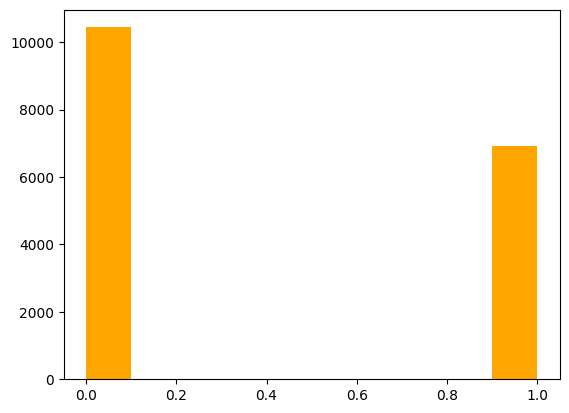

In [13]:
# histogram of the 'success' variable
df["success"].plot(kind='hist', color='orange', edgecolor='none')
plt.ylabel('')
plt.grid(False)
plt.show()

**It can be seen from the matrix that there is a high correlation between 'atemp' and 'temp'.**

In [14]:
# calculates the pairwise Pearson correlation coefficients
df[["temp", "atemp", "hum", "windspeed", "weekday", "success"]].corr()

,temp,atemp,hum,windspeed,weekday,success
temp,1.000000,0.987672,-0.069881,-0.023125,-0.001795,0.382151
atemp,0.987672,1.000000,-0.051918,-0.062336,-0.008821,0.381635
hum,-0.069881,-0.051918,1.000000,-0.290105,-0.037158,-0.301252
windspeed,-0.023125,-0.062336,-0.290105,1.000000,0.011502,0.072834
weekday,-0.001795,-0.008821,-0.037158,0.011502,1.000000,0.035353
success,0.382151,0.381635,-0.301252,0.072834,0.035353,1.000000


**Checking if all your features are between 0 and 1:**

In [15]:
# Prepare features and labels
# - Select the required features (temp, atemp, hum, windspeed, weekday)
X = df[['temp', 'atemp', 'hum', 'windspeed', 'weekday']].to_numpy()

# Check if all values in each column of X are between 0 and 1
feature_min = X.min(axis=0)
feature_max = X.max(axis=0)

print("Minimum values per feature:", feature_min)
print("Maximum values per feature:", feature_max)

all_between_0_and_1 = np.all((X >= 0) & (X <= 1))
print("All data between 0 and 1:", all_between_0_and_1)

Minimum values per feature: [0. 0. 0. 0. 0.]
Maximum values per feature: [1. 1. 1. 1. 1.]
All data between 0 and 1: True


In [16]:
# - Split the data into training (75%), validation (10%), and test (15%) sets
# Prepare features and labels
# - Select the required features (temp, atemp, hum, windspeed, weekday)
# X = df[['temp', 'atemp', 'hum', 'windspeed', 'weekday']].to_numpy()
y = df["success"].to_numpy()

# Train/test split (75% train, 25% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# From train set, split off 10% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# Reshape to match network input format
X_train, X_val, X_test = X_train.T, X_val.T, X_test.T
y_train = y_train[np.newaxis, :]
y_val = y_val[np.newaxis, :]
y_test = y_test[np.newaxis, :]


### Model Training


In [17]:
# TODO: Train the neural network
# - Create DataLoader objects with batch_size=8
# Initialize model
# - Implement the network with architecture [5, 40, 30, 10, 7, 5, 3, 1]
nn = MyNN(0.01, [5, 40, 30, 10, 7, 5, 3, 1])

# - Use batch_size=8 as specified
batch_size = 8
# - Train for exactly 100 epochs on the training set
epochs = 100

# - Calculate and store train and validation loss for each epoch
# Train and get loss traces
train_losses, val_losses = train(X_train, y_train, X_val, y_val, epochs, batch_size, verbose=False)

### Visualization

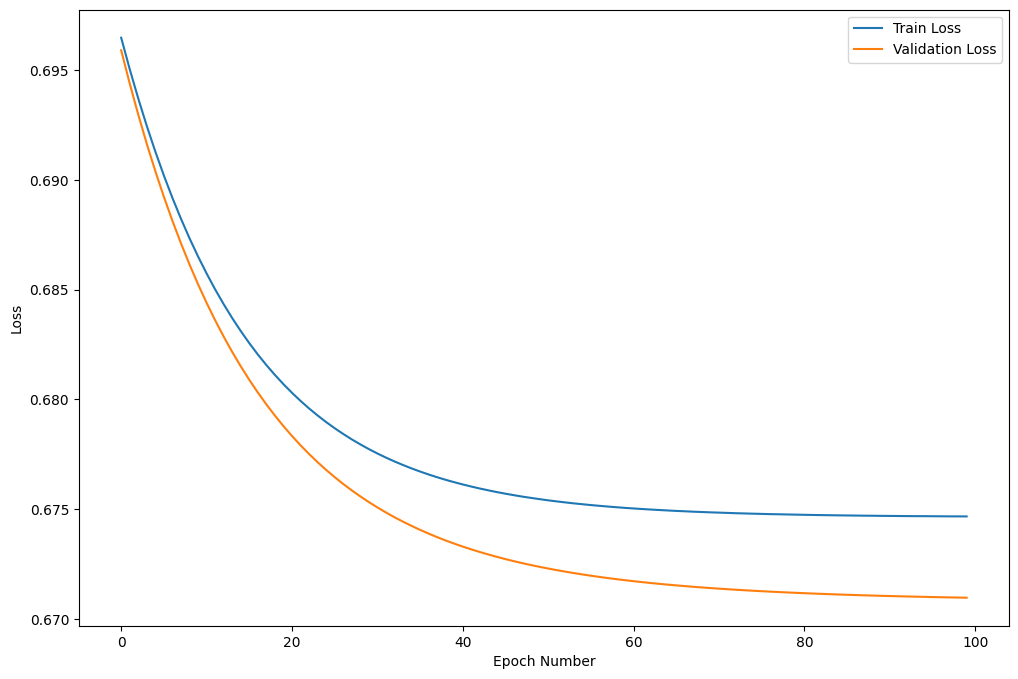

In [18]:
# TODO: Create visualizations of the learning process
# - Track training progres
# Plot training and validation loss per epoch
# - Make sure all plots have proper labels, titles, and legends
# - Compare test performance with training/validation performance
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# - Add brief analysis of what the plots reveal about your model's performance

**NOTE:**
* Both train and validation loss decrease steadily → model is learning
* Final losses plateau around 0.67 → possible underfitting
* Feature normalization was successful → helps training stability

**Checking for overfitting:**

In [20]:
# - Discuss any overfitting/underfitting issues observed

if val_losses[-1] > train_losses[-1]:
    print("Warning: Validation loss is higher than training loss — possible overfitting.")
elif val_losses[-1] < train_losses[-1]:
    print("Validation loss is lower than training loss — could be underfitting or easy validation set.")
else:
    print("Training and validation losses are close — model may be well-tuned.")


Validation loss is lower than training loss — could be underfitting or easy validation set.


**NOTE:**
* Validation loss is lower than training loss → no overfitting detected
* This may indicate **underfitting** or that the **validation set is easier** than the training set
* Model might still benefit from more training, better features, or a tuned architecture

**Prediction on test set:**

In [21]:

pred = nn.forward_batch(X_test)
pred.shape, y_test.shape


((1, 4345), (1, 4345))

**ROC Curve:**

We will plot ROC curve - Doing Binary Classification

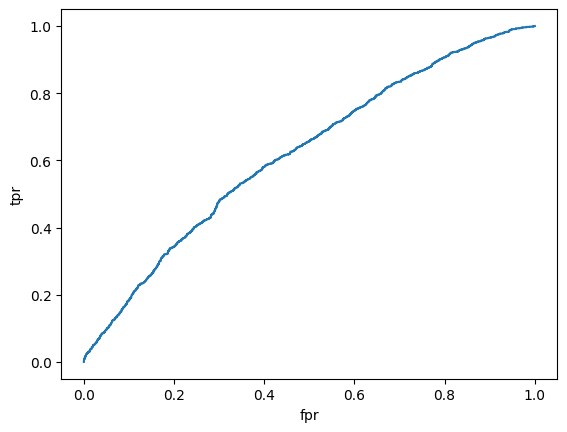

AUC= 0.6200493324972801


In [22]:
# - Create additional relevant plots (validation loss, learning curves, etc.)
pred = pred[0]
y_test = y_test[0]

fpr, tpr, thresholds = roc_curve(y_test, pred)
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

auc = roc_auc_score(y_test, pred)
print("AUC=", auc)

**NOTE:**

**Brief conclusions** based on the ROC curve and AUC score:

---

* ROC curve is close to the diagonal → model has limited discriminative power
* AUC = **0.62** → slightly better than random (0.5), but still weak performance
* Indicates the model is learning **some signal**, but not enough for reliable classification
* Likely underfitting → consider improving feature quality, increasing training time, or adjusting model architecture/hyperparameters

**Confution matrix:**

Best threshold (Youden's J): 0.40782743366625585


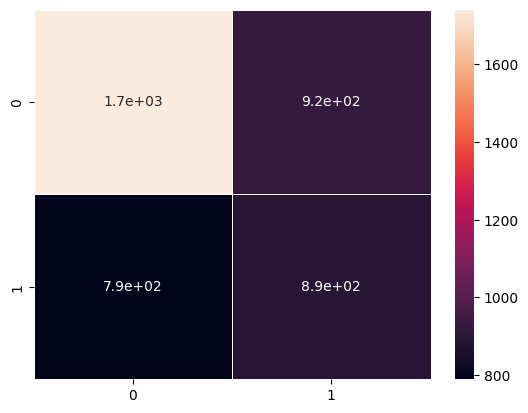

              precision    recall  f1-score   support

         0.0       0.69      0.65      0.67      2664
         1.0       0.49      0.53      0.51      1681

    accuracy                           0.61      4345
   macro avg       0.59      0.59      0.59      4345
weighted avg       0.61      0.61      0.61      4345



In [23]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

fpr, tpr, thresholds = roc_curve(y_test, pred)
j_scores = tpr - fpr
best_threshold = thresholds[np.argmax(j_scores)]
print("Best threshold (Youden's J):", best_threshold)

threshold = best_threshold

y_pred = pred > threshold

# - Analyze model strengths and weaknesses

# confusion_matrix
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,  annot=True, linewidth=0.5)
plt.show()

# report
print(classification_report(y_test,y_pred))

**NOTE:**

* **Accuracy: 61%** → matches previous evaluation, confirms limited model performance
* **Class 0 (negative)** is predicted better than **Class 1 (positive)**

  * Precision: 0.69 vs 0.49
  * Recall: 0.65 vs 0.53
* **F1-score for Class 1** is only **0.51** → weak ability to detect positives
* **Youden's J optimal threshold (0.4078)** improves balance slightly, but not dramatically
* Model shows **bias toward predicting Class 0** (majority class)

### Model Evaluation


In [24]:
# TODO: Evaluate model performance on the test set

# Final test set evaluation
test_loss = nn.log_loss_batch(pred[np.newaxis, :], y_test[np.newaxis, :])
test_accuracy = np.mean((pred > threshold) == y_test)

# - Calculate and report the loss on the test set
print("Final Test Loss:", test_loss)

# - Calculate and report the accuracy on the test set
print("Final Test Accuracy:", test_accuracy)

Final Test Loss: 0.6682461664013686
Final Test Accuracy: 0.6059838895281934


**NOTE:**

* **Final Test Loss: 0.6682** → slightly better than random guess (0.693), but still high
* **Final Test Accuracy: \~60.6%** → confirms previous evaluations (model is learning weak patterns)
* Performance aligns with ROC AUC (0.62) and classification report
* Overall, the model shows **modest improvement over random**, but still **underfitting**

_______

# **For summary:**

* The model trains correctly with steadily decreasing loss and no overfitting.
* Final loss (\~0.668) and AUC (0.62) show performance only slightly better than random.
* Accuracy (\~60%) confirms weak predictive power, especially for the positive class.
* Model likely underfits — deeper training, better features, or hyperparameter tuning is needed.

**Options for improving the model to achieve better results:**
* Train for more epochs (e.g., 200+)
* Remove redundant features (e.g., drop `atemp`)
* Add regularization (e.g., L2) or dropout
* Try a simpler or wider architecture
* Balance the dataset or apply class weighting